## Linear Regression Analysis between the Atlantic Multidecadal Oscillation and ERA5 monthly averaged precipitation, Cloud cover, and precipitable water anomalies over Africa

### Import linregress package

In [1]:
from scipy.stats import linregress


### First, do regression analysis between ERA5 data variables for continental, weighted  African region

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import NaturalEarthFeature
from cartopy.feature import COASTLINE
from clim680_function import xyticks
from climo_anoms_function import climo
from climo_anoms_function import anoms

In [6]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


In [7]:
f= '/scratch/areed29/ERA5data/*.nc' #loads in Netcdf ERA5data
DS1 = xr.open_mfdataset(f) #opens the file
data_lat= DS1.latitude #latitudes
data_lon= DS1.longitude #longitudes
nlats = len(data_lat[:])
nlons = len(data_lon[:])
time = DS1.time
#Extracts variables
total_cloud_cover = DS1.tcc
total_precip = DS1.tp
column_cloud_lw= DS1.tclw
total_column_wv = DS1.tcwv
ds_mean_1 = DS1.mean(dim=('time','expver')) #this removes the expver variable in the dataset by averaging over that dimension
total_cloud_cover_1 = ds_mean_1.tcc.values #total cloud cover
total_precip_1= ds_mean_1.tp.values #total precipitation
column_cloud_lw_1 = ds_mean_1.tclw.values #total column cloud liquid water
total_column_watervapor = ds_mean_1.tcwv.values #total column cloud water vapor

In [8]:
# First, calculate climatology; without any weighting or masking
ds_mean = DS1.mean(dim=('expver'))
ds_climo= climo(ds_mean)
ds_anoms = anoms(ds_mean)
print(ds_anoms)

<xarray.Dataset>
Dimensions:    (latitude: 401, longitude: 241, time: 513)
Coordinates:
  * longitude  (longitude) float32 -20.0 -19.75 -19.5 -19.25 ... 39.5 39.75 40.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... -49.5 -49.75 -50.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-09-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 11 12 1 2 3 4 5 6 7 8 9
Data variables: (12/34)
    cbh        (time, latitude, longitude) float32 dask.array<chunksize=(1, 401, 241), meta=np.ndarray>
    cp         (time, latitude, longitude) float32 dask.array<chunksize=(1, 401, 241), meta=np.ndarray>
    crr        (time, latitude, longitude) float32 dask.array<chunksize=(1, 401, 241), meta=np.ndarray>
    hcc        (time, latitude, longitude) float32 dask.array<chunksize=(1, 401, 241), meta=np.ndarray>
    ilspf      (time, latitude, longitude) float32 dask.array<chunksize=(1, 401, 241), meta=np.ndarray>
    lsm        (time, latitude, longitude) float32 das

### Next, Normalization of anomalies

In [9]:
#Calculating sigma (standard deviation) for each variable 
clouds_std = ds_anoms['tcc'].std()
precip_std = ds_anoms['tp'].std()
tcwv_std_0 = ds_anoms['tcwv'].std()
tcc_norm= ds_anoms['tcc']/clouds_std
tp_norm=ds_anoms['tp']/precip_std
tcwv_norm=ds_anoms['tcwv']/tcwv_std_0

### Apply masking

In [10]:
# Apply masking
mask = ds_mean.lsm #loads in land-sea mask
tcc_masked = tcc_norm.where(mask>0.5)
tp_masked = tp_norm.where(mask>0.5)
tcwv_masked = tcwv_norm.where(mask>0.5)
print(tp_masked)

<xarray.DataArray 'tp' (time: 513, latitude: 401, longitude: 241)>
dask.array<where, shape=(513, 401, 241), dtype=float32, chunksize=(1, 401, 241), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -20.0 -19.75 -19.5 -19.25 ... 39.5 39.75 40.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... -49.5 -49.75 -50.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-09-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 11 12 1 2 3 4 5 6 7 8 9


### Apply weighting

In [11]:
# Apply cosine weighting
rad = 4.*np.arctan(1.)/180.
clat = np.cos(data_lat*rad)
tcc_weighted = tcc_masked.weighted(clat).mean(dim=('latitude','longitude')).load()
tp_weighted = tp_masked.weighted(clat).mean(dim=('latitude','longitude')).load()
tcwv_weighted = tcwv_masked.weighted(clat).mean(dim=('latitude','longitude')).load()

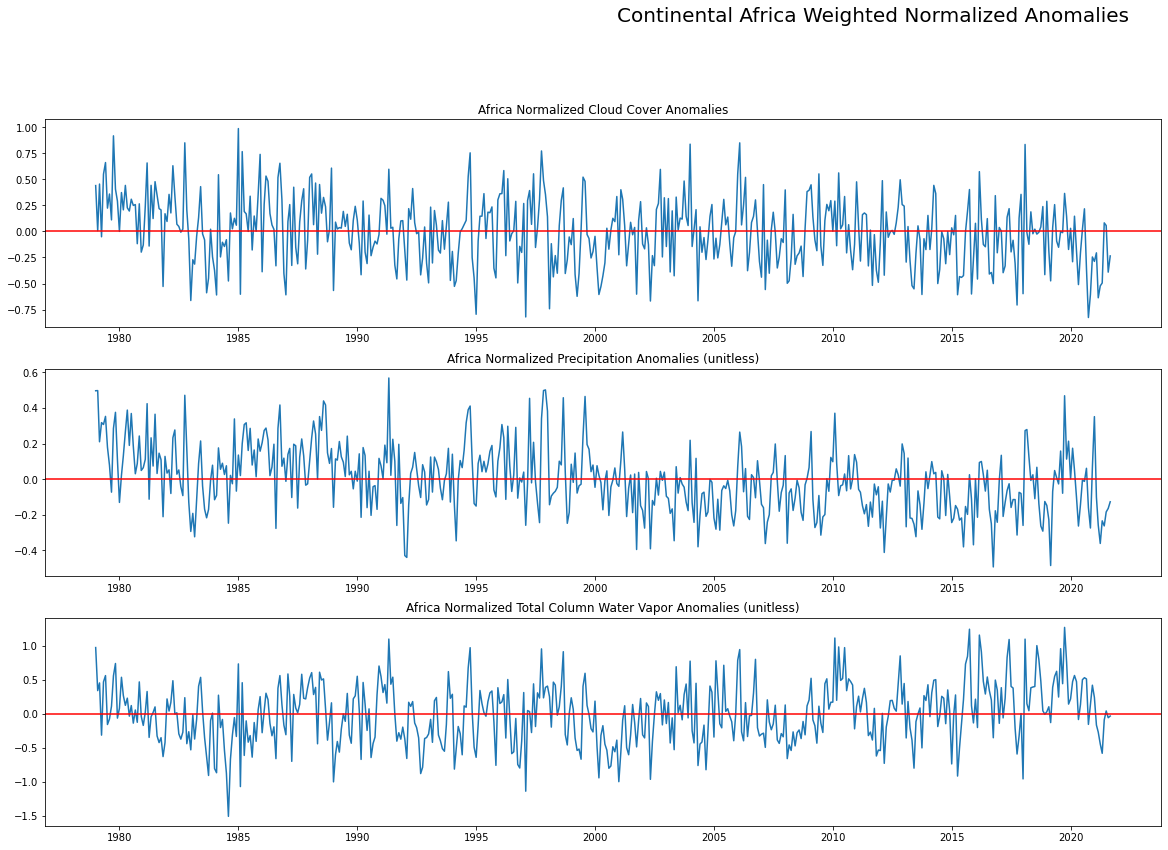

In [12]:
fig = plt.figure(figsize=(20,13))
# Set height padding for plots
fig.set_constrained_layout_pads(w_pad=0., h_pad=0.1, hspace=0., wspace=0.)
#First plot: Total Cloud Cover
ax_cloudcover = fig.add_subplot(3,1,1)
ax_cloudcover.plot(tcc_weighted['time'],tcc_weighted)
ax_cloudcover.axhline(y=0.0, color='r', linestyle='-')
ax_cloudcover.set_title('Africa Normalized Cloud Cover Anomalies') 
#Second plot: Total Precip
ax_precip = fig.add_subplot(3,1,2)
ax_precip.plot(tp_weighted['time'], tp_weighted)
ax_precip.axhline(y=0.0, color='r', linestyle='-')
ax_precip.set_title('Africa Normalized Precipitation Anomalies (unitless)') 
#Third plot: Total Column Cloud Water Vapor
ax_wv = fig.add_subplot(3,1,3)
ax_wv.plot(tcwv_weighted['time'],tcwv_weighted)
ax_wv.axhline(y=0.0, color='r', linestyle='-')
ax_wv.set_title('Africa Normalized Total Column Water Vapor Anomalies (unitless)') 
plt.suptitle('Continental Africa Weighted Normalized Anomalies',x=0.7,y=1,fontsize = 20)
plt.savefig('/homes/areed29/CLIM680_Fall2021/final_project/figures/cont_norm_weighted_anoms')

### Fit a line to each time series (employing Linear Regression)

In [13]:
x_values = np.linspace(0,1,len(tcc_weighted['time'])) #Creates an evenly spaced array for the x axis
#Cloud cover
[m_fit_clouds,b_fit_clouds]=np.polyfit(x_values,tcc_weighted,1) #Least squares polynomial fit
print(b_fit_clouds,m_fit_clouds)
y_fit_clouds = m_fit_clouds*x_values+b_fit_clouds #Creates the line of best fit
#total precipitation
[m_fit_precip,b_fit_precip]=np.polyfit(x_values,tp_weighted,1)
print(b_fit_precip,m_fit_precip)
y_fit_precip = m_fit_precip*x_values+b_fit_precip
#precipitable water
[m_fit_tcwv,b_fit_tcwv]=np.polyfit(x_values,tcwv_weighted,1)
print(b_fit_tcwv,m_fit_tcwv)
y_fit_tcwv = m_fit_tcwv*x_values+b_fit_tcwv

0.12865794087386304 -0.25731590626245554
0.13126642622048781 -0.26253285791136116
-0.13164290837315953 0.26328584171003033


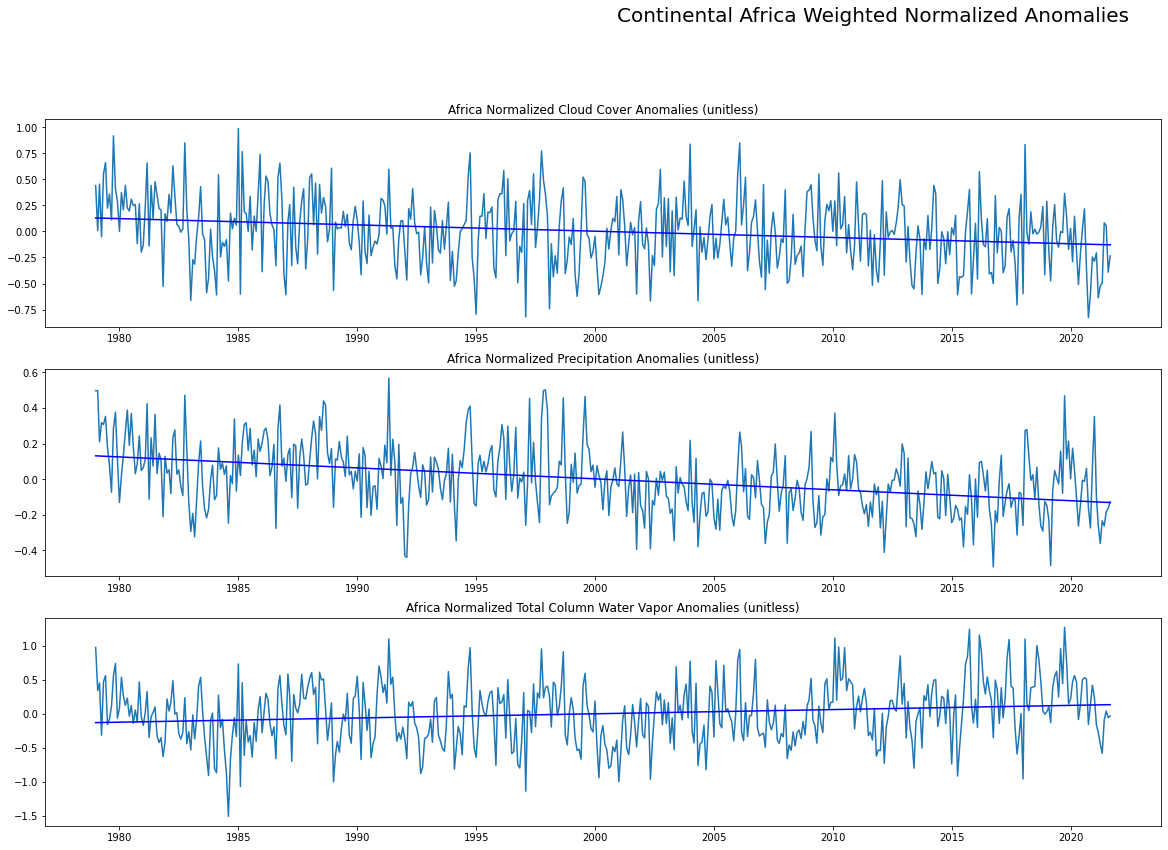

In [14]:
fig = plt.figure(figsize=(20,13))
# Set height padding for plots
fig.set_constrained_layout_pads(w_pad=0., h_pad=0.1, hspace=0., wspace=0.)
#First plot: Total Cloud Cover
ax_cloudcover = fig.add_subplot(3,1,1)
ax_cloudcover.plot(tcc_weighted['time'],tcc_weighted)
ax_cloudcover.plot(tcc_weighted['time'],y_fit_clouds,'b-')
#ax_cloudcover.axhline(y=0.0, color='r', linestyle='-')
ax_cloudcover.set_title('Africa Normalized Cloud Cover Anomalies (unitless)') 
#Second plot: Total Precip
ax_precip = fig.add_subplot(3,1,2)
ax_precip.plot(tp_weighted['time'], tp_weighted)
ax_precip.plot(tp_weighted['time'],y_fit_precip,'b-')
#ax_precip.axhline(y=0.0, color='r', linestyle='-')
ax_precip.set_title('Africa Normalized Precipitation Anomalies (unitless)') 
#Fourth plot: Total Column Cloud Water Vapor
ax_wv = fig.add_subplot(3,1,3)
ax_wv.plot(tcwv_weighted['time'],tcwv_weighted)
ax_wv.plot(tcwv_weighted['time'],y_fit_tcwv,'b-')
#ax_wv.axhline(y=0.0, color='r', linestyle='-')
ax_wv.set_title('Africa Normalized Total Column Water Vapor Anomalies (unitless)') 
plt.suptitle('Continental Africa Weighted Normalized Anomalies',x=0.7,y=1,fontsize = 20)
plt.savefig('/homes/areed29/CLIM680_Fall2021/final_project/figures/cont_norm_weighted_anoms_withtrend')
#Note: the horizontal line centered at 0 is removed in order to visualize the best-fit trend line


### Linear regression between Cloud cover anomalies and precipitation anomalies

In [15]:
slope, intercept, r_value, p_value, std_err = linregress(tcc_weighted, tp_weighted) #Calculates slope, intercept, r value, p value, and standard error
slope,intercept,r_value,p_value,std_err

(0.36079674723656946,
 4.695084126554275e-09,
 0.6304776382483317,
 3.351368630840136e-58,
 0.019649896252633987)

In [16]:
r_sq=r_value**2 #calculates a coefficient of determination (r-squred value)
r_sq


0.39750205233119423

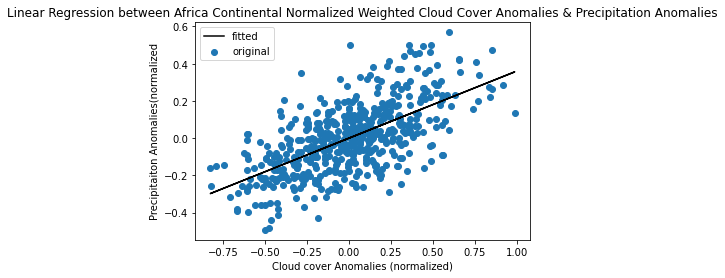

In [17]:
plt.scatter(tcc_weighted, tp_weighted)
plt.plot(tcc_weighted, intercept + slope*tcc_weighted, 'k')
plt.legend(['fitted','original'])
plt.xlabel('Cloud cover Anomalies (normalized)')
plt.ylabel('Precipitaiton Anomalies(normalized')
plt.title('Linear Regression between Africa Continental Normalized Weighted Cloud Cover Anomalies & Precipitation Anomalies')
plt.savefig('/homes/areed29/CLIM680_Fall2021/final_project/figures/regression_clouds_precip')

### Linear Regression between precipitation anomalies and precipitable water anomalies

In [18]:
slope, intercept, r_value, p_value, std_err = linregress(tp_weighted, tcwv_weighted)
slope,intercept,r_value,p_value,std_err

(1.0394482398112623,
 9.295071379256115e-09,
 0.44012186004779313,
 1.0218507204995066e-25,
 0.09381361153572129)

In [19]:
r_sq=r_value**2
r_sq


0.1937072516919292

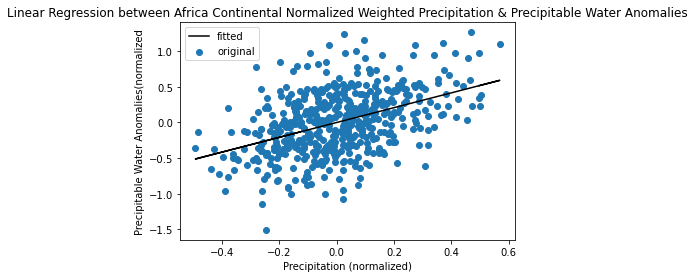

In [20]:
plt.scatter(tp_weighted, tcwv_weighted)
plt.plot(tp_weighted, intercept + slope*tp_weighted, 'k')
plt.legend(['fitted','original'])
plt.xlabel('Precipitation (normalized)')
plt.ylabel('Precipitable Water Anomalies(normalized')
plt.title('Linear Regression between Africa Continental Normalized Weighted Precipitation & Precipitable Water Anomalies')
plt.savefig('/homes/areed29/CLIM680_Fall2021/final_project/figures/regression_precip_tcwv')

### Linear Regression between cloud cover anomalies and precipitable water anomalies

In [21]:
slope, intercept, r_value, p_value, std_err = linregress(tcc_weighted, tcwv_weighted)
slope,intercept,r_value,p_value,std_err

(0.815223659364925,
 1.9903658324653605e-08,
 0.6031897055350943,
 3.777287198087327e-52,
 0.0476865965314713)

In [22]:
r_sq=r_value**2
r_sq


0.3638378208635138

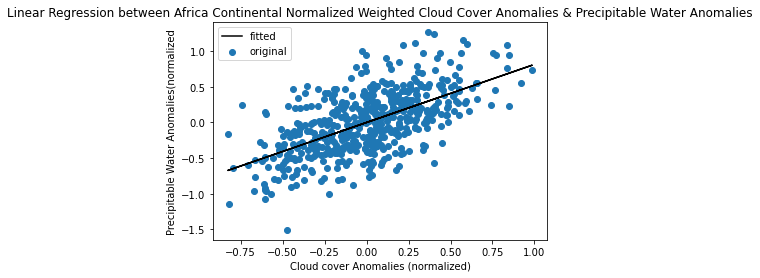

In [23]:
plt.scatter(tcc_weighted, tcwv_weighted)
plt.plot(tcc_weighted, intercept + slope*tcc_weighted, 'k')
plt.legend(['fitted','original'])
plt.xlabel('Cloud cover Anomalies (normalized)')
plt.ylabel('Precipitable Water Anomalies(normalized')
plt.title('Linear Regression between Africa Continental Normalized Weighted Cloud Cover Anomalies & Precipitable Water Anomalies')
plt.savefig('/homes/areed29/CLIM680_Fall2021/final_project/figures/regression_clouds_tcwv')

### Regression with AMO

In [24]:
#Climate index of choice: Atlantic Multidecadal Oscillation (AMO)
path='/homes/areed29/CLIM680_Fall2021/CLIM_INDICES/'
file='amon.us.data'
index_name='amo'

df=pd.read_table(path+file,skiprows=1,
                 header=None,delim_whitespace=True,
                 index_col=0,parse_dates=True,na_values=['-99.99','-99.990'])
df.drop(df.tail(5).index,inplace=True)


In [25]:
start_date=str(df.index[0])+'-'+str(df.columns[0])+'-01'
end_date=str(df.index[-1])+'-'+str(df.columns[-1])+'-01'
print(start_date)

1948-1-01


In [26]:
dates=pd.date_range(start=start_date,end=end_date,freq='MS')
dates

DatetimeIndex(['1948-01-01', '1948-02-01', '1948-03-01', '1948-04-01',
               '1948-05-01', '1948-06-01', '1948-07-01', '1948-08-01',
               '1948-09-01', '1948-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=876, freq='MS')

In [27]:
clim_index=df.T.unstack().values
ds_index=xr.DataArray(clim_index,
                      coords={'time':dates},
                              dims=['time'])        
ds_index=ds_index.to_dataset(name='amo')
ds_index

<xarray.Dataset>
Dimensions:  (time: 876)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2020-12-01
Data variables:
    amo      (time) object '-0.019' '-0.031' '0.024' ... 0.297 0.12 0.17

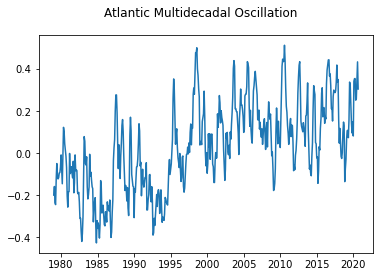

In [28]:
#Slice array to be consistent with precip data
sliced_amo=ds_index.sel(time=slice(ds_index['time'][372],ds_index['time'][-4]))
#print(sliced_amo)
#Warm AMO- above 0
#Cold AMO-below 0
amo_values = sliced_amo.amo
#print(nao_values)
amo_float = amo_values.astype(float)
#print(amo_float)
warm_amo=amo_float.where(amo_float>0.0)
cold_amo = amo_float.where(amo_float<0.0)
plt.plot(amo_float['time'],amo_float)
plt.suptitle('Atlantic Multidecadal Oscillation')
plt.savefig('/homes/areed29/CLIM680_Fall2021/final_project/figures/AMO_defined_noshading')

In [29]:
### Slice ERA5 data to match with AMO index dates
precip_anoms=tp_weighted.sel(time=slice(ds_index['time'][0],ds_index['time'][-4])).load()
clouds_anoms=tcc_weighted.sel(time=slice(ds_index['time'][0],ds_index['time'][-4])).load()
prec_water_anoms=tcwv_weighted.sel(time=slice(ds_index['time'][0],ds_index['time'][-4])).load()

In [30]:
### Slicing with masked array for maps
precip_anoms_full=tp_masked.sel(time=slice(ds_index['time'][0],ds_index['time'][-4])).load()
#precip_anoms_full_1=tp_norm.sel(time=slice(ds_index['time'][0],ds_index['time'][-4]))
clouds_anoms_full=tcc_masked.sel(time=slice(ds_index['time'][0],ds_index['time'][-4])).load()
prec_water_anoms_full=tcwv_masked.sel(time=slice(ds_index['time'][0],ds_index['time'][-4])).load()

### Linear Regression between AMO index and cloud cover anomalies

In [31]:
slope, intercept, r_value, p_value, std_err = linregress(clouds_anoms, amo_float)
slope,intercept,r_value,p_value,std_err

(-0.05600950306978262,
 0.029464167315225987,
 -0.08750702063249587,
 0.0502844649538068,
 0.02854298239411945)

In [32]:
r_sq=r_value**2
r_sq

0.007657478659976057

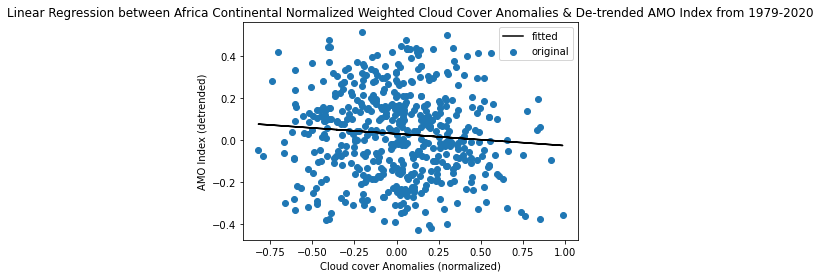

In [33]:
plt.scatter(clouds_anoms, amo_float)
plt.plot(clouds_anoms, intercept + slope*clouds_anoms, 'k')
plt.legend(['fitted','original'])
plt.xlabel('Cloud cover Anomalies (normalized)')
plt.ylabel('AMO Index (detrended)')
plt.title('Linear Regression between Africa Continental Normalized Weighted Cloud Cover Anomalies & De-trended AMO Index from 1979-2020')
plt.savefig('/homes/areed29/CLIM680_Fall2021/final_project/figures/regression_clouds_amo')

### Linear Regression between AMO index and precipitation anomalies

In [34]:
slope, intercept, r_value, p_value, std_err = linregress(precip_anoms, amo_float)
slope,intercept,r_value,p_value,std_err

(-0.2686931118491031,
 0.029899462106174682,
 -0.24126118274744637,
 4.560698171993454e-08,
 0.04838341811293452)

In [35]:
r_sq=r_value**2
r_sq

0.058206958300696714

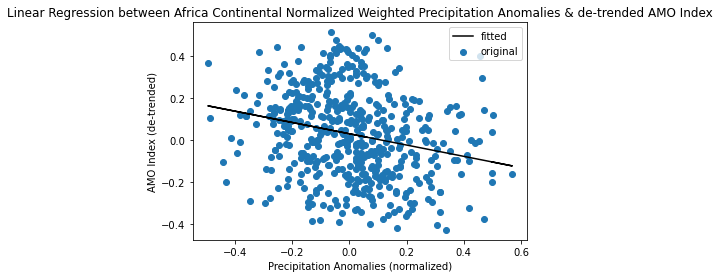

In [36]:
plt.scatter(precip_anoms, amo_float)
plt.plot(precip_anoms, intercept + slope*precip_anoms, 'k')
plt.legend(['fitted','original'])
plt.xlabel('Precipitation Anomalies (normalized)')
plt.ylabel('AMO Index (de-trended)')
plt.title('Linear Regression between Africa Continental Normalized Weighted Precipitation Anomalies & de-trended AMO Index')
plt.savefig('/homes/areed29/CLIM680_Fall2021/final_project/figures/regression_precip_amo')

### Linear Regression between AMO index and precipitable water anomalies

In [37]:
slope, intercept, r_value, p_value, std_err = linregress(prec_water_anoms, amo_float)
slope,intercept,r_value,p_value,std_err

(0.12610333237146729,
 0.028736319100938802,
 0.271065169377846,
 6.918023620913674e-10,
 0.020046143477480412)

In [38]:
r_sq=r_value**2
r_sq

0.07347632604984035

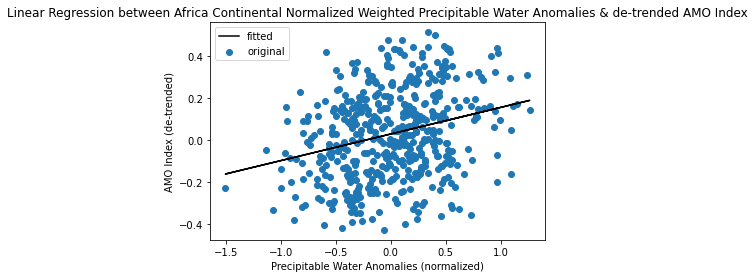

In [40]:
plt.scatter(prec_water_anoms, amo_float)
plt.plot(prec_water_anoms, intercept + slope*prec_water_anoms, 'k')
plt.legend(['fitted','original'])
plt.xlabel('Precipitable Water Anomalies (normalized)')
plt.ylabel('AMO Index (de-trended)')
plt.title('Linear Regression between Africa Continental Normalized Weighted Precipitable Water Anomalies & de-trended AMO Index')
plt.savefig('/homes/areed29/CLIM680_Fall2021/final_project/figures/regression_tcwv_amo')

### Plotting Regression Maps

In [54]:
### Cloud cover variable
nx=len(clouds_anoms_full['longitude']) #length of longitude array
ny=len(clouds_anoms_full['latitude']) # length of latitude array
slope_0_clouds = np.zeros((ny,nx)) #Create empty arrays for all parameters
intercept_0_clouds = np.zeros((ny,nx))
r_value_0_clouds = np.zeros((ny,nx))
p_value_0_clouds = np.zeros((ny,nx))
std_err_0_clouds= np.zeros((ny,nx))
for i in range(nx):
    for j in range(ny):
        slope, intercept, r_value, p_value, std_err = linregress(amo_float, clouds_anoms_full[:,j,i]) # computes linear regression for all lat,lon points
        slope_0_clouds[j,i]=slope
        intercept_0_clouds[j,i]=intercept
        r_value_0_clouds[j,i]=r_value
        p_value_0_clouds[j,i] = p_value
        std_err_0_clouds[j,i]=std_err
print(slope_0_clouds.shape)

(401, 241)


In [55]:
# use np.where to mask significant reg coeff in a similar manner as we have done for compositing and correlations to mask where the regression is
# significantly different from 0
mask_sig_clouds=np.where(p_value_0_clouds<0.05,r_value_0_clouds,np.nan)
print(mask_sig_clouds)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [56]:
### Precipitation variable

nx=len(precip_anoms_full['longitude'])
ny=len(precip_anoms_full['latitude'])
slope_0_precip = np.zeros((ny,nx))
intercept_0_precip = np.zeros((ny,nx))
r_value_0_precip = np.zeros((ny,nx))
p_value_0_precip = np.zeros((ny,nx))
std_err_0_precip= np.zeros((ny,nx))
for i in range(nx):
    for j in range(ny):
        slope, intercept, r_value, p_value, std_err = linregress(amo_float, precip_anoms_full[:,j,i])
        slope_0_precip[j,i]=slope
        intercept_0_precip[j,i]=intercept
        r_value_0_precip[j,i]=r_value
        p_value_0_precip[j,i] = p_value
        std_err_0_precip[j,i]=std_err
print(slope_0_precip.shape)

(401, 241)


In [57]:
# use np.where to mask significant reg coeff in a similar manner as we have done for compositing and correlations
mask_sig_precip=np.where(p_value_0_precip<0.05,r_value_0_precip,np.nan)
print(mask_sig_precip)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [58]:
### Precipitable water variable
nx=len(prec_water_anoms_full['longitude'])
ny=len(prec_water_anoms_full['latitude'])
slope_0_tcwv = np.zeros((ny,nx))
intercept_0_tcwv = np.zeros((ny,nx))
r_value_0_tcwv = np.zeros((ny,nx))
p_value_0_tcwv = np.zeros((ny,nx))
std_err_0_tcwv= np.zeros((ny,nx))
for i in range(nx):
    for j in range(ny):
        slope, intercept, r_value, p_value, std_err = linregress(amo_float, prec_water_anoms_full[:,j,i])
        slope_0_tcwv[j,i]=slope
        intercept_0_tcwv[j,i]=intercept
        r_value_0_tcwv[j,i]=r_value
        p_value_0_tcwv[j,i] = p_value
        std_err_0_tcwv[j,i]=std_err
print(slope_0_tcwv.shape)

(401, 241)


In [59]:
# use np.where to mask significant reg coeff in a similar manner as we have done for compositing and correlations
mask_sig_tcwv=np.where(p_value_0_tcwv<0.05,r_value_0_tcwv,np.nan)
print(mask_sig_tcwv)

[[       nan        nan        nan ... 0.10821847 0.11057027 0.11249742]
 [       nan        nan        nan ... 0.10837054 0.11061286 0.11259565]
 [       nan        nan        nan ... 0.10819709 0.11047389 0.11192079]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


In [60]:
### Create a list of all significance and slope arrays for all variables
all_slopes=[slope_0_clouds,slope_0_precip,slope_0_tcwv]
all_mask_sig = [mask_sig_clouds,mask_sig_precip,mask_sig_tcwv]
all_anoms = [clouds_anoms_full,precip_anoms_full,prec_water_anoms_full]

### Plot the Regression Coefficients

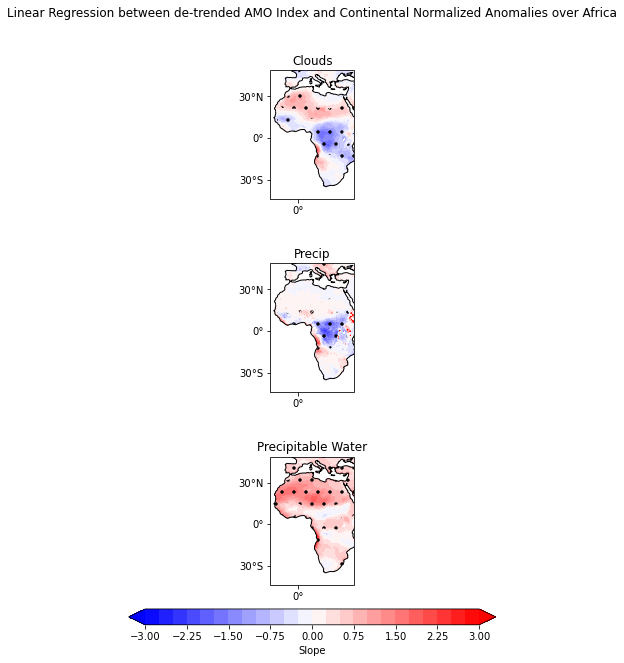

In [63]:
labels=['Clouds','Precip', 'Precipitable Water']
clevs=np.arange(-3,3.25,0.25)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=3,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,11))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the variables and plot
for i, trend in enumerate(all_slopes):

        # Select the variable
        data=all_slopes[i]
        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=all_anoms[i]['longitude'])
        mask_data,lons = add_cyclic_point(all_mask_sig[i],coord=all_anoms[i]['longitude'])
        # Contour plot
        cs=axs[i].contourf(lons,all_anoms[i]['latitude'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='bwr',extend='both')
        axs[i].contourf(lons,all_anoms[i]['latitude'],mask_data,[0,1],transform= ccrs.PlateCarree(),colors='None',
                       hatches =['.','.'], extend ='both', alpha=0)
       # Longitude and latitude labels
        xyticks(axs[i],lons,all_anoms[i]['latitude'])
        #Set extent for the plots
        axs[i].set_extent([-20,40,-40,45])
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i])
        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs,cax =cbar_ax,orientation='horizontal',shrink=0.7,
                 label='Slope')
# Add a big title at the top
plt.suptitle('Linear Regression between de-trended AMO Index and Continental Normalized Anomalies over Africa')
plt.savefig('/homes/areed29/CLIM680_Fall2021/final_project/figures/regressionmap_AMO_allanoms_withsig')

### Zoom in on precipitation variable

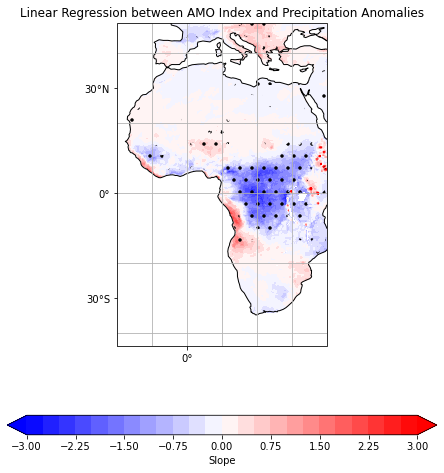

In [64]:
clevs=np.arange(-3,3.25,0.25)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree())

# Add cyclic point
data=slope_0_precip
data,lon=add_cyclic_point(data,coord=precip_anoms_full['longitude'])
mask_data,lons=add_cyclic_point(mask_sig_precip,coord=precip_anoms_full['longitude'])

# Make a filled contour plot
cs=ax.contourf(lon,precip_anoms_full['latitude'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='bwr',extend='both')

ax.contourf(lon,precip_anoms_full['latitude'],mask_data,[0,1],
            transform = ccrs.PlateCarree(),colors='None',
            hatches=['.','.'],extend='both',alpha=0)

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()

xyticks(ax,lon,precip_anoms_full['latitude'])
ax.set_extent([-20,40,-40,45])
# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Slope')

# Add title
plt.title('Linear Regression between AMO Index and Precipitation Anomalies')
plt.savefig('/homes/areed29/CLIM680_Fall2021/final_project/figures/regressionmap_AMO_precipanoms_withsig')

### Next, create a dataset out of the trends (slopes) for each variable

In [65]:
ds_m_precip=xr.DataArray(slope_0_precip,
                  coords={'latitutde':precip_anoms_full['latitude'],
                          'longitude': precip_anoms_full['longitude']},
                  dims=['latitude','longitude'])        
ds_m_precip=ds_m_precip.to_dataset(name='slope_precip')
ds_m_precip

<xarray.Dataset>
Dimensions:       (latitude: 401, longitude: 241)
Coordinates:
    latitutde     (latitude) float32 50.0 49.75 49.5 ... -49.5 -49.75 -50.0
  * longitude     (longitude) float32 -20.0 -19.75 -19.5 ... 39.5 39.75 40.0
Dimensions without coordinates: latitude
Data variables:
    slope_precip  (latitude, longitude) float64 nan nan nan nan ... nan nan nan

In [66]:
ds_m_clouds=xr.DataArray(slope_0_clouds,
                  coords={'latitutde':clouds_anoms_full['latitude'],
                          'longitude': clouds_anoms_full['longitude']},
                  dims=['latitude','longitude'])        
ds_m_clouds=ds_m_clouds.to_dataset(name='slope_clouds')
ds_m_clouds

<xarray.Dataset>
Dimensions:       (latitude: 401, longitude: 241)
Coordinates:
    latitutde     (latitude) float32 50.0 49.75 49.5 ... -49.5 -49.75 -50.0
  * longitude     (longitude) float32 -20.0 -19.75 -19.5 ... 39.5 39.75 40.0
Dimensions without coordinates: latitude
Data variables:
    slope_clouds  (latitude, longitude) float64 nan nan nan nan ... nan nan nan

In [67]:
ds_m_tcwv=xr.DataArray(slope_0_tcwv,
                  coords={'latitutde':prec_water_anoms_full['latitude'],
                          'longitude': prec_water_anoms_full['longitude']},
                  dims=['latitude','longitude'])        
ds_m_tcwv=ds_m_tcwv.to_dataset(name='slope_tcwv')
ds_m_tcwv

<xarray.Dataset>
Dimensions:     (latitude: 401, longitude: 241)
Coordinates:
    latitutde   (latitude) float32 50.0 49.75 49.5 49.25 ... -49.5 -49.75 -50.0
  * longitude   (longitude) float32 -20.0 -19.75 -19.5 ... 39.5 39.75 40.0
Dimensions without coordinates: latitude
Data variables:
    slope_tcwv  (latitude, longitude) float64 nan nan nan nan ... nan nan nan

In [68]:
ds_regr=xr.merge([ds_m_clouds,ds_m_precip,ds_m_tcwv]) #Merges the 3 datasets
ds_regr

<xarray.Dataset>
Dimensions:       (latitude: 401, longitude: 241)
Coordinates:
    latitutde     (latitude) float32 50.0 49.75 49.5 ... -49.5 -49.75 -50.0
  * longitude     (longitude) float32 -20.0 -19.75 -19.5 ... 39.5 39.75 40.0
Dimensions without coordinates: latitude
Data variables:
    slope_clouds  (latitude, longitude) float64 nan nan nan nan ... nan nan nan
    slope_precip  (latitude, longitude) float64 nan nan nan nan ... nan nan nan
    slope_tcwv    (latitude, longitude) float64 nan nan nan nan ... nan nan nan

### Write them to a single .nc file

In [69]:
ds_regr.to_netcdf('/homes/areed29/CLIM680_Fall2021/regression.nc') #converts the dataset to a single netcdf file
ds_check=xr.open_dataset('/homes/areed29/CLIM680_Fall2021/regression.nc') #opens the new dataset
ds_check

<xarray.Dataset>
Dimensions:       (latitude: 401, longitude: 241)
Coordinates:
    latitutde     (latitude) float32 ...
  * longitude     (longitude) float32 -20.0 -19.75 -19.5 ... 39.5 39.75 40.0
Dimensions without coordinates: latitude
Data variables:
    slope_clouds  (latitude, longitude) float64 ...
    slope_precip  (latitude, longitude) float64 ...
    slope_tcwv    (latitude, longitude) float64 ...

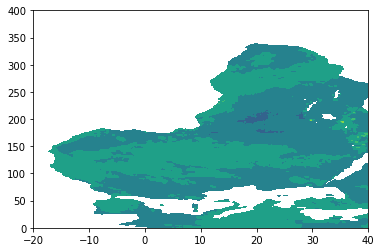

In [70]:
plt.contourf(ds_check['longitude'],ds_check['latitude'],ds_check['slope_precip']) #Plot the precip slope as a check